In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
torch.set_printoptions(linewidth=120)

In [ ]:
# init params
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download=True,
    transform = transforms.Compose([
      transforms.ToTensor()                 
    ]   
    )
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size = 64, shuffle=True
)


test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = False,
    transform = transforms.Compose([
      transforms.ToTensor()                 
    ]   
    )
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size = 64, shuffle=True
)

#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyper paramters
num_classes = 10
num_epochs  = 15
batch_size = 4
learning_rate = 0.001

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)

In [ ]:
len(train_set)

60000

In [ ]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
train_set.targets.bincount()


tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
sample = next(iter(train_set))
print(len(sample))
type(sample)

2


tuple

In [ ]:
image, label = sample
print(image.shape)
print(label)
#label.shape

torch.Size([1, 28, 28])
9



label:  9


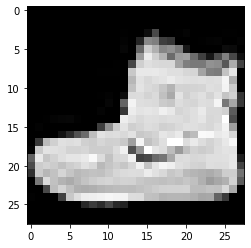

In [ ]:
plt.imshow(image.squeeze(), cmap='gray')
print('label: ', label)

In [ ]:
batch = next(iter(train_loader))
len(batch)

2

In [ ]:
type(batch)

list

In [ ]:
images, labels = batch

In [ ]:
labels.shape

torch.Size([64])

In [ ]:
images.shape

torch.Size([64, 1, 28, 28])

labels:  tensor([4, 8, 6, 9, 5, 5, 7, 0, 4, 2, 4, 4, 4, 2, 1, 2, 1, 6, 5, 4, 5, 6, 2, 3, 5, 0, 5, 9, 8, 1, 5, 9, 5, 5, 6, 5, 1,
        3, 3, 3, 1, 9, 1, 9, 6, 9, 2, 0, 6, 0, 5, 5, 9, 1, 5, 9, 7, 0, 0, 7, 2, 7, 2, 9])


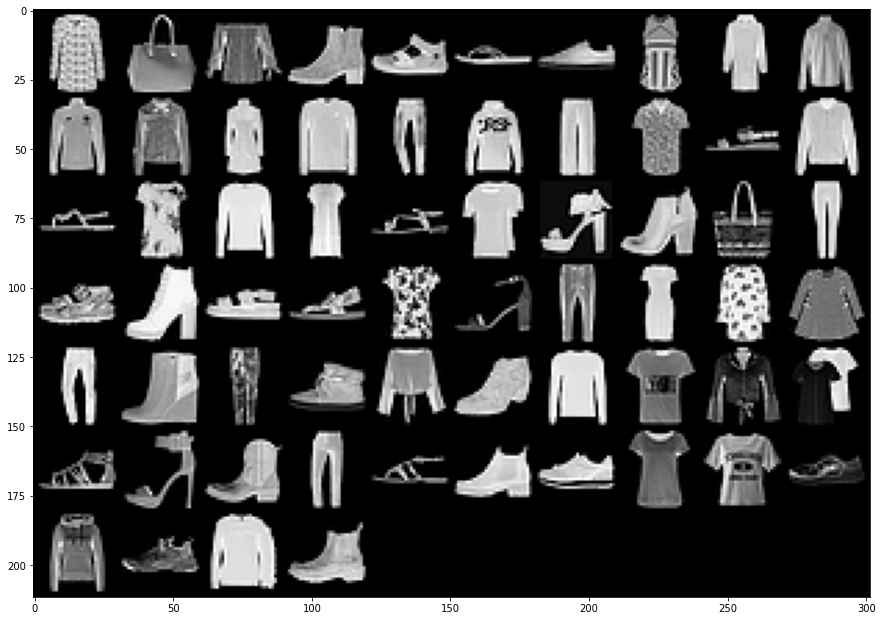

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1, 2 ,  0)))
print('labels: ', labels)

In [ ]:
class ConvNet(nn.Module):
  
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(4*4*50, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x
    

In [ ]:
model = ConvNet().to(device)
model

ConvNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
n_total_steps = len(train_loader) # 600
for e in range(num_epochs):
  n_loss = 0.0
  n_correct = 0.0

  for i, (images, labels) in enumerate(train_loader): 
    images = images.to(device)
    labels = labels.to(device)
    output= model(images)
    loss = criterion(output, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # print every 100th iteration
    if ((i+1)%100 == 0):
      print(f'epoch {e+1}/{num_epochs}, step {i*1}/{n_total_steps}, loss = {loss.item():.4f}')
  else:
    with torch.no_grad():
      n_correct = 0.0
      n_samples = 0.0

      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, preds = torch.max(output, 1)
        #print(labels.shape[0])
        # batch_size
        n_samples += labels.shape[0]

        # correct preds within a batch_size of samples
        n_correct += (preds == labels).sum().item() 

        # overall accuracy
        acc = 100.0 * n_correct/n_samples
        print(f'epoch {e+1}/{num_epochs}, accuracy = {acc}')
    

epoch 1/15, step 99/938, loss = 0.7286
epoch 1/15, step 199/938, loss = 0.5911
epoch 1/15, step 299/938, loss = 0.3406
epoch 1/15, step 399/938, loss = 0.5445
epoch 1/15, step 499/938, loss = 0.4324
epoch 1/15, step 599/938, loss = 0.3781
epoch 1/15, step 699/938, loss = 0.5209
epoch 1/15, step 799/938, loss = 0.2989
epoch 1/15, step 899/938, loss = 0.3228
epoch 1/15, accuracy = 92.1875
epoch 1/15, accuracy = 86.71875
epoch 1/15, accuracy = 85.9375
epoch 1/15, accuracy = 84.375
epoch 1/15, accuracy = 83.75
epoch 1/15, accuracy = 83.85416666666667
epoch 1/15, accuracy = 83.48214285714286
epoch 1/15, accuracy = 84.375
epoch 1/15, accuracy = 84.72222222222223
epoch 1/15, accuracy = 85.0
epoch 1/15, accuracy = 85.36931818181819
epoch 1/15, accuracy = 85.546875
epoch 1/15, accuracy = 85.09615384615384
epoch 1/15, accuracy = 84.93303571428571
epoch 1/15, accuracy = 84.89583333333333
epoch 1/15, accuracy = 84.66796875
epoch 1/15, accuracy = 84.8345588235294
epoch 1/15, accuracy = 84.809027777